In [33]:
import pandas as pd
import numpy as np
import re
import tweepy
import pymongo
import matplotlib.pylab as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## 1) Main goal

### Main algorithmic reference: Python Machine Learning 2nd Edition by Sebastian Raschka

#### Perform topic modelling on collected tweets on a particular topic to observe people's opinion on that subject using Latent Dirichlet Allocation algorithm

#### For this particular topic, the keyword 'jerusalem' was chosen for the analysis. The reason for the topic is described in tweepy_test.py, but I'll highlight some issues using twitter API.

## 2) Challenges with using twitter API

#### Reference: https://developer.twitter.com/en/docs/tweets/search/overview

The actual data collection using twitter was performed using twitter Open API's standard account, which is the free version of twitter's API service. The free version comes with several limitations. For one thing, the API only collects data from recent 7 days. The problem with this was that it limited the scope of subjects we can analyze. If a particular topic isn't a popular topic at the moment, there were only around maybe 3000~4000 tweets available using the Open API (I experienced this issue using keywords such as 'tesla', 'samsung galaxy s8', 'machine learning')

I originally wanted to perform analysis on people's opinion on a firm or a product. The problem is if a product has been out for a while, amongst the sprase number of tweets that were collected, majority of them were advertisements, which are pretty much noise in our data analysis. Clearly, if the same analysis was performed within a short period of time when a product was released, we could perform a more meaningful topic analysis.

Hence, I was limited to choosing a topic that was fairly recent and gained attention of a large population. As of the timeline when this project was conducted (late December, 2017), Trump has officially declared that U.S will recognize Jerusalem as official capital of Israel, and I wanted to see how topics regarding Jerusalem were spread out. When I performed the analysis, I was easily able to amass 80,000 tweets, although some were filtered out in the end because they were too short to have any meaningful context.

## 3) Twitter data colleciton 

This portion was deployed in Spyder and is presented in tweepy_test.py. But the code will be included here again for reference.

In [ ]:
def text_preprocessing(text):
    '''Simple text preprocessing method for cleansing the data'''
    '''Some Regex references:
    https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet'''
    #Let us analyze everything in lower case
    text = text.lower()
    #Get rid of http
    result = re.sub(r"http\S+", "", text)
    #ignore any person tagging
    result = re.sub(r"@([A-Za-z]+[A-Za-z0-9_]+)", "", result)
    result = re.sub(r"\?", "", result)
    #No need for hashtags
    result = re.sub(r"#", "", result)
    #Remove quotation marks and unnecessary punctuations
    result = re.sub(r'"', "", result)
    result = re.sub(r"'", "", result)
    result = re.sub(r",", "", result)
    result = re.sub(r"-", "", result)
    result = re.sub(r":", "", result)
    result = re.sub(r";", "", result)
    #Remove any brackets
    result = re.sub(r"\(", "", result)
    result = re.sub(r"\)", "", result)
    result = re.sub(r"&", "", result)
    #This call is to reduce all white space to single space and get rid of
    #trailing whitespace using .strip() method
    result = re.sub('\s+', ' ', result).strip()
    #Some twits had these weird units
    result = re.sub(r"£", "", result)
    result = re.sub(r"\.", "", result)
    result = re.sub(r"|", "", result)
    result = re.sub(r"\!", "", result)
    #Remove any price tag
    return result

'''First set up a connection to MongoDB'''
username = 'cck3'
password = 'ck1445CK'
connection = pymongo.MongoClient('mongodb://%s:%s@52.78.226.78' % (username, password))

'''Make a new db called twitter'''
db = connection.twitter

'''Make a new collection called hmm... twitter_collection'''
twitter_collection = db.twitter_collection
twitter_collection_unfiltered = db.twitter_collection_unfiltered

'''Now connect to Twitter Open API using keys and secrets'''
consumer_key = 'WJxqR6SL4JgQW2XwNlVmrCMDi'
consumer_secret = 'Y5OzWd956VjbyCoTeAYqzSoQ5MfSBAjgo95w5u0SQYM35Wx2uQ'

access_token = '946046842919202817-7JuPQBiEE7wIjlkNMwhql6khr2But2r'
access_token_secret = '6hZf8fzXOEwn7QG1eOEq7VCEeIZhCNrB1PAHpjNkn1DtY'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

'''Reference for rate limit: 
    https://stackoverflow.com/questions/21308762/avoid-twitter-api-limitation-with-tweepy'''
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

'''This keyword is used to search tweet. -filter:retweets is there to make 
sure retweets are filtered out'''
key = 'jerusalem -filter:retweets'

count = 1
'''Reference on tweet_mode input: 
https://twittercommunity.com/t/retrieve-full-tweet-when-truncated-non-retweet/75542/4
https://developer.twitter.com/en/docs/tweets/tweet-updates'''

'''Reading the tweet data and saving them in MongoDB'''
for tweet in tweepy.Cursor(api.search, q=key, include_entities=True, lang="en", tweet_mode="extended").items(80000):
    #Keep the original
    tweet_dict_unfiltered = {'original_tweet' : tweet.full_text}
    twitter_collection_unfiltered.insert_one(tweet_dict_unfiltered)
    
    #Insert the filtered tweets
    tweet_mod = text_preprocessing(tweet.full_text)
    tweet_dict = {'filtered_tweet' : tweet_mod}
    twitter_collection.insert_one(tweet_dict)
    
    if count % 1 == 0:
        print(str(count) + ':' + tweet_mod)
        print('-' * 30)
    count += 1
    
'''Problem with using Twitter is that... due to the fact the free account only allows
data from past 7 days, it is diifficult to gather large data in a particular topic. 
Also, the problem with streaming a product data is that there are
way too many ads on twitter to extract anything meaningful

My guess is that there would probably more meaningful reviews from people when a product
is just released. But when I tried Samsung Galaxy S8, which has been out for a while,
most of the tweets (around 4000) consisted largely of advertisements.

Also, non-popular topics like Tesla or Machine Learning did not have much tweets either.

So I finally decided to pick a subject that is hotly debated topic - jerusalem.'''

'''Let us call the saved data in DataFrame and save it as a csv file'''
tweet_list = []
for tweet in twitter_collection.find():
    '''Let us filter out tweets that are too short'''
    if len(tweet['filtered_tweet']) < 40:
        continue
    tweet_list.append(tweet['filtered_tweet'])
    
tweet_df = pd.DataFrame(tweet_list, columns = ['filtered_tweet'])
tweet_df.to_csv('filtered_tweet.csv', index = False, encoding = 'utf-8')

In [34]:
tweet_df = pd.read_csv('filtered_tweet.csv')

In [35]:
tweet_df.head(10)

,filtered_tweet
0,And if every country in the middle east is inv...
1,Jews are new to Zionism Nice try As the UN den...
2,TYTlive so was urnor Moore that got Trumps sup...
3,Joe roots captaincy this series has been solid...
4,Nehemiah 1243 And on that day they made great ...
5,63 Israeli students signed a letter stating th...
6,Neh 122829 amp d sons of the musicmakers came ...
7,US says cuts to UN budget unrelated to Jerusal...
8,Countries Supporting Trump Decision To Recogni...
9,Top story From Trump to Jerusalem The year tha...


In [36]:
tweet_df.tail(10)

,filtered_tweet
76419,Irish Times Letters UN defies Trump to condemn...
76420,EU Germany to finance 40m euro wastewater trea...
76421,How your cowardly UNGA’s Jerusalem vote worked...
76422,The campaign was created by Dr Mike Evans a pr...
76423,Priceless NY Post Cover Burns UN Snowflakes Ag...
76424,CNN’s Jake Tapper trashes nations condemning T...
76425,GOD BLESS PRESIDENT TRUMP Boeing WellsFargo Bb...
76426,Israel quits UNESCO over ‘attacks’ months afte...
76427,Use Social Media against israel Every boy girl...
76428,Your former boss promised the exact same thing...


## 4) LDA 

#### We have some hyperparameters that we need to tune such as number of topics and max_df in CountVectorizer, so we will try several cases until a result that makes the most sense is observed. To make these observations, we will analyze the top words for each topic

### 4 topics

In [107]:
def show_top_words(num_words, count, lda):
    n_top_words = num_words
    feature_names = count.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic {}:".format(topic_idx + 1))
        '''argsort returns the indices that would sort an array in ascending fasion. 
        In other words, it would sort the index of words such that 
        the most important words for each category can be found at the tail of the list.
        Consequently, to extract top 10 important elements, we need to extract last 10 elements
        from the sorted list'''
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 : -1]]))
        print('-' * 30)
        print()

In [108]:
count = CountVectorizer(stop_words = 'english')
X = count.fit_transform(tweet_df['filtered_tweet'].values)

In [109]:
lda4 = LatentDirichletAllocation(n_topics = 4, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics4 = lda4.fit_transform(X)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [110]:
show_top_words(15, count, lda4)

Topic 1:
jerusalem embassy guatemala israel trump moving says trumps countries president decision announces christmas embassies lead
------------------------------

Topic 2:
jerusalem christmas peace pope israel world trump amp just calls good like merry day know
------------------------------

Topic 3:
jerusalem israel capital palestine jews amp christians east city jewish palestinians people god years holy
------------------------------

Topic 4:
jerusalem trump israel station vote capital train israeli president decision donald wall western new minister
------------------------------



### 5 topics

In [39]:
lda5 = LatentDirichletAllocation(n_topics = 5, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics5 = lda5.fit_transform(X)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [48]:
show_top_words(15, count, lda5)

Topic 1:
jerusalem embassy guatemala israel trump moving says countries president trumps decision embassies lead announces following
------------------------------

Topic 2:
jerusalem christmas peace pope israel trump calls merry nations francis amp world united message day
------------------------------

Topic 3:
jerusalem israel capital palestine amp christians jews city east jewish holy god palestinians people years
------------------------------

Topic 4:
jerusalem trump israel station capital train president israeli donald vote wall western new decision minister
------------------------------

Topic 5:
jerusalem vote palestinian haley trump just nikki like israeli funding violence israel christmas dont million
------------------------------



### 6 topics

In [43]:
lda6 = LatentDirichletAllocation(n_topics = 6, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics6 = lda6.fit_transform(X)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [49]:
show_top_words(15, count, lda6)

Topic 1:
jerusalem israel embassy guatemala moving says countries embassies trump 10 decision capital president talks trumps
------------------------------

Topic 2:
jerusalem christmas peace pope amp calls merry god trump world message people francis israel good
------------------------------

Topic 3:
jerusalem israel capital palestine jews east amp city christians holy jewish netanyahu people times king
------------------------------

Topic 4:
jerusalem capital trump israel vote cut decision countries israeli israels voted make budget united nations
------------------------------

Topic 5:
jerusalem palestinian israeli nikki haley christmas violence bethlehem vote million like 285 funding palestinians jews
------------------------------

Topic 6:
jerusalem trump embassy israel guatemala station train president donald wall new trumps western following decision
------------------------------



#### We begin to see a bit of repetition of keywords in different topics which is indicative of unoptimized modeling

### 7 topics 

In [50]:
lda7 = LatentDirichletAllocation(n_topics = 7, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics7 = lda7.fit_transform(X)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [51]:
show_top_words(15, count, lda7)

Topic 1:
jerusalem embassy israel guatemala moving says president decision palestine iran news trumps christmas palestinians hamas
------------------------------

Topic 2:
jerusalem christmas peace pope calls merry francis message united nations trump day solution palestine hate
------------------------------

Topic 3:
jerusalem israel capital palestine jews amp east jewish people city christians holy jesus land years
------------------------------

Topic 4:
jerusalem vote cut make budget capital 285m israel israeli trump obama video palestinians care know
------------------------------

Topic 5:
jerusalem haley vote nikki palestinian israeli christmas violence bethlehem million india funding 285 trumps like
------------------------------

Topic 6:
jerusalem trump embassy guatemala israel station train president wall new trumps western following lead donald
------------------------------

Topic 7:
jerusalem capital trump israel countries decision embassies israels recognition 10 recogn

#### We begin to see a bit of repetition of keywords such as embassy across multiple topics here

### 8 topics

In [52]:
lda8 = LatentDirichletAllocation(n_topics = 8, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics8 = lda8.fit_transform(X)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [54]:
show_top_words(15, count, lda8)

Topic 1:
jerusalem embassy israel guatemala moving says president decision capital country trump palestinians trumps iran just
------------------------------

Topic 2:
jerusalem christmas pope peace trump nations message francis merry united amp world good solution people
------------------------------

Topic 3:
jerusalem israel east jews christians amp palestine capital netanyahu king middle times city jesus david
------------------------------

Topic 4:
jerusalem israel peace god land people holy capital years jewish know obama city calls pope
------------------------------

Topic 5:
jerusalem haley palestinian nikki israeli vote million funding like 285 jews muslims palestine announces reduction
------------------------------

Topic 6:
jerusalem trump embassy guatemala israel station train wall new president western following lead trumps donald
------------------------------

Topic 7:
jerusalem israel trump capital countries embassies 10 israels recognize decision talks world says m

#### Now, we start seeing the embassy issue present many different topics and some of the topics seem to lack consistency. For instance, topic 4 seems to have a random array of topics.

### It appears that 4 topics (5 seems pretty acceptable as well) division is optimal as it doesn't have duplicating themes and each topic has clear theme. However, as we have seen in the above analysis, there are a lotta repetitive terms occurring multiple occasions; let us adjust the max_df in CountVectorizer and observe how that handles things.

### 4-2) Tuning max_df parameter

In [55]:
count2 = CountVectorizer(stop_words = 'english', max_df = 0.5)
X2 = count2.fit_transform(tweet_df['filtered_tweet'].values)

In [56]:
lda5_2 = LatentDirichletAllocation(n_topics = 5, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics5_2 = lda5_2.fit_transform(X2)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [57]:
show_top_words(15, count, lda5_2)

Topic 1:
trumotrain israel popculture christmas haley nikkei decision funding peacd millineal capital francis 285 votd trumprussia
------------------------------

Topic 2:
israel capital trumotrain votd amp worl decision peope jusswaggtv christmas nationother makdisi god countries lik
------------------------------

Topic 3:
embassy guatemala israel trumotrain statingwe movin presidencyhouseampsenateis trails saynototerrorism countries walkway nevertrumppastors decision westelbian embassies
------------------------------

Topic 4:
israel christmas bethlehem christians jesuits jewry yearrrr palestinans trumprussia violators capital israeli palestinia netanyahou kinds
------------------------------

Topic 5:
palestinans capital israeli israel peacd palestinia east palestinianruled city calls iran stataliste vida popculture et
------------------------------



#### For some reason, this creates a more gibberish kind of a result. But this is probably due to the fact that Tweets are in general short. Just to make sure, let us try a slightly different max_df value to see how that performs.

In [126]:
count3 = CountVectorizer(stop_words = 'english', max_df = 0.7)
X3 = count3.fit_transform(tweet_df['filtered_tweet'].values)

In [127]:
lda5_3 = LatentDirichletAllocation(n_topics = 5, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics5_3 = lda5_3.fit_transform(X3)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [128]:
show_top_words(15, count, lda5_3)

Topic 1:
trumotrain israel popculture christmas haley nikkei decision funding peacd millineal capital francis 285 votd trumprussia
------------------------------

Topic 2:
israel capital trumotrain votd amp worl decision peope jusswaggtv christmas nationother makdisi god countries lik
------------------------------

Topic 3:
embassy guatemala israel trumotrain statingwe movin presidencyhouseampsenateis trails saynototerrorism countries walkway nevertrumppastors decision westelbian embassies
------------------------------

Topic 4:
israel christmas bethlehem christians jesuits jewry yearrrr palestinans trumprussia violators capital israeli palestinia netanyahou kinds
------------------------------

Topic 5:
palestinans capital israeli israel peacd palestinia east palestinianruled city calls iran stataliste vida popculture et
------------------------------



#### Similar story here, due to the character limits in tweets, it apears that including all the words give a better result. Now we'll do more in depth analysis.

#### In the movie review topic modeling case in Python Machine learning, adjusting the max_df values helped the result because each review was much longer, and filtering out words that do not contribute much to topic differentiation actually helped. Obviously not for twitter topic modeling.

### 4-3) Tuning ngram hyperparameter

ngram hyperparameter allows one to group multiple words as single word. For instance, in some cases, the keyword 'SK hynix' may have more meaning than individual 'SK' and 'hynix'.

In [67]:
count_n2 = CountVectorizer(ngram_range = (1,2), stop_words = 'english')
X_n2 = count_n2.fit_transform(tweet_df['filtered_tweet'].values)

### 5 topics

In [68]:
lda_n2_5 = LatentDirichletAllocation(n_topics = 5, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics_n2_5 = lda_n2_5.fit_transform(X_n2)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [76]:
show_top_words(15, count_n2, lda_n2_5)

Topic 1:
jerusalem embassy israel guatemala moving embassy jerusalem israel jerusalem embassy israel moving embassy says trump guatemala says palestine says moving president
------------------------------

Topic 2:
jerusalem embassy embassy jerusalem guatemala israel trump trumps guatemala embassy decision christmas following lead israel embassy bethlehem follows
------------------------------

Topic 3:
jerusalem trump station vote israel train train station new president haley countries jerusalem vote jerusalem train nikki cut
------------------------------

Topic 4:
jerusalem god israel embassy amp trumps bless city god bless christians say netanyahu president jerusalem embassy christmas
------------------------------

Topic 5:
jerusalem capital israel jerusalem capital trump capital israel palestine decision christmas israeli jerusalem israel palestinian capital palestine israels countries
------------------------------



### 6 topics

In [77]:
lda_n2_6 = LatentDirichletAllocation(n_topics = 6, random_state = 0, learning_method = 'batch', n_jobs = -1)
X_topics_n2_6 = lda_n2_6.fit_transform(X_n2)

C:\Users\cck3\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [78]:
show_top_words(15, count_n2, lda_n2_6)

Topic 1:
jerusalem embassy guatemala israel embassy jerusalem moving israel jerusalem embassy israel moving embassy says guatemala says president trump says moving palestine
------------------------------

Topic 2:
jerusalem embassy israel guatemala embassy jerusalem trump trumps decision guatemala embassy christmas lead following follows bethlehem israel embassy
------------------------------

Topic 3:
jerusalem trump vote station israel train train station countries new haley president jerusalem train jerusalem vote nikki cut
------------------------------

Topic 4:
jerusalem god embassy israel bless amp trumps god bless jerusalem embassy netanyahu city president say christians ban
------------------------------

Topic 5:
jerusalem israel capital trump jerusalem capital capital israel israeli decision wall station western jerusalem israel western wall palestine donald
------------------------------

Topic 6:
jerusalem christmas israel pope peace capital palestine palestinian peace je

#### With increased ngram, we are running into a similar issue with max_df variation. We begin to have keywords occurring across multiple topics. 

#### For final analysis, we will take the case with 1st order ngram and max_df set at default value with 4 divisions. The results should be fairly similar.

## 5) In depth analysis of optimal topic model

### 4 topics, 1st order ngram, max_df = 1.0

In [111]:
show_top_words(15, count, lda4)

Topic 1:
jerusalem embassy guatemala israel trump moving says trumps countries president decision announces christmas embassies lead
------------------------------

Topic 2:
jerusalem christmas peace pope israel world trump amp just calls good like merry day know
------------------------------

Topic 3:
jerusalem israel capital palestine jews amp christians east city jewish palestinians people god years holy
------------------------------

Topic 4:
jerusalem trump israel station vote capital train israeli president decision donald wall western new minister
------------------------------



### Distribution of topics (topic_num = 4)

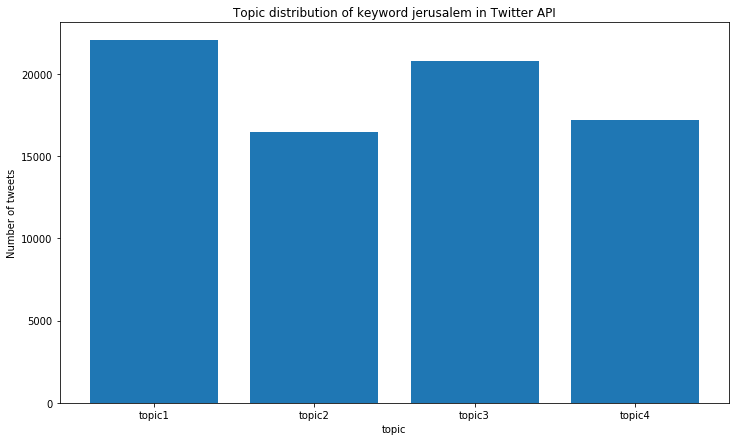

In [112]:
X_topics4_np = np.array(X_topics4)
topic_distribution = np.argmax(X_topics4_np, axis = 1)
topic_count = np.bincount(topic_distribution)

plt.figure(figsize = (12, 7))
plt.bar(range(len(topic_count)), topic_count)
plt.xticks(range(len(topic_count)), ('topic1', 'topic2', 'topic3', 'topic4'))
plt.ylabel('Number of tweets')
plt.xlabel('topic')
plt.title('Topic distribution of keyword jerusalem in Twitter API')
plt.show()

Tweets about Christmas and a train station being named after Donald Trump is slightly less popular topic as opposed to the news of Guatemala and other countries re-locating their embassies in Jerusalem and the historical tweets about Jerusalem. The Christmas tweet is probably just a coincidence in time frame because the timeline for tweet collection occurs between December 22nd and December 29th.

### Let us print out some tweets from each topic and see if topic modeling indeed divided the tweets properly

In [115]:
topic_4_1 = X_topics4[:, 0].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_4_1[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

Israel regulator seeks to ban bitcoin firms from stock exchange JERUSALEM Reuters Israels markets regulator said on Monday he will propose regulation to ban companies based on bitcoin and other digital currencies from trading on the Tel Aviv Stock Exchange TASE
--------------------------------------------------

Israel regulator seeks to ban bitcoin firms from stock exchange JERUSALEM Reuters Israels markets regulator said on Monday he will propose regulation to ban companies based on bitcoin and other digital currencies from trading on the Tel Aviv Stock Exchange TASE
--------------------------------------------------

follow me Israel praises Guatemala over Jerusalem embassy move JERUSALEM/GUATEMALA CITY Reuters Guatemalan President Jimmy Morales drew praise from Israeli officials on Monday for deciding to relocate the Central American countrys embassy to… topNews follow for follow
--------------------------------------------------

UPDATE 1Israel regulator seeks to ban bitcoin firms

#### The main topic here appears to be mention of Guatemala moving its embassy to Jerusalem following President Trump's decision to recognize Jerusalem as the capital city of Israel, and other countries also moving their embassy. Inevitably some noise is present in the data.

In [116]:
topic_4_2 = X_topics4[:, 1].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_4_2[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

I love it thank you Lord watching the enemy turn against their own enemies classic Islamic inbreeding to the extreme and the acute Isn’t Islam the religion of peace ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day Happy Rosh Hashanah Yom Kippur Sukkot Simchat Torah Thanksgiving Hanukkah a very Merry Christmas and a Happy New Year Happy Birthday Jesus💞😇
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day Happy Rosh Hashanah Yom Kippur Sukkot Simchat Torah Thanksgiving Hanukkah a very Merry Christmas and a Happy New Year Happy Birthday Jesus💞😇
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day H

#### Mainly Christmas and Pope were central keywrods

In [117]:
topic_4_3 = X_topics4[:, 2].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_4_3[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

No Justice No Peace BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS
--------------------------------------------------

5045 Jerusalem as a spaceport 10257 beacon Pyramids 5620 wars of the Gods amp pyramid 11110 amp 14700 nuke wars 11600 Exodus 11400 Marduk/Babylon 3300 12 planets 3835 Anki bio of 4125 gold expeditions 4510 humanity origin via
--------------------------------------------------

amp the Black sea amp ThraceAnatolia amp Karaman amp the City of Dulkadir amp Diyarbakir amp The Lord of Kurdistan Persia AzerbaijanDamascus amp AllepoEgypt amp HijazThe Kingdom of Jerusalem amp all of Arabia amp Yemen amp many more that I amp my Glorious Ancestors with The Will of Allah conquered
--------------------------------------------------

YiddishSaying Fast of 10th Tevet Jerusalem Under Siege There are 3 pairs of fasts man and woman a l

#### This was the most unexpected topic. It appears to be containing tweets mentioning the history of Jerusalem and the relation of Israelians and Palestanians. I assume these tweets come from people arguing the historical context of Jerusalem

In [118]:
topic_4_4 = X_topics4[:, 3].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_4_4[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

Jerusalem Israel plans Trump station near Western Wall BBC News BBC News Jerusalem Israel plans Trump station near Western Wall BBC News Israels transport minister wants to dig a railway tunnel under Jerusalems Old City and name a station 
--------------------------------------------------

Israeli Minister Wants to Name a Jerusalem Train Station for Trump New York Times New York Times Israeli Minister Wants to Name a Jerusalem Train Station for Trump New York Times JERUSALEM — In the uneasy days after President Trump recognized Jeru
--------------------------------------------------

In Israela Station named after US Prez Trump  For his Historic decision 2 recognise Jerusalem as d capital of Israel Israels transport min Yisrael Katz is finalizing a plan 2 dig a Rly tunnel passing thru HolySites in Jerusalems OldCity amp end at WestWall Trump Station
--------------------------------------------------

Israel considers naming new Jerusalem train station after Donald Trump Israel Transpo

#### A train station near the western wall of Jerusalem is to be named after Donald Trump apparently

### 5 topics, 1st order ngram, max_df = 1.0

In [119]:
show_top_words(15, count, lda5)

Topic 1:
jerusalem embassy guatemala israel trump moving says countries president trumps decision embassies lead announces following
------------------------------

Topic 2:
jerusalem christmas peace pope israel trump calls merry nations francis amp world united message day
------------------------------

Topic 3:
jerusalem israel capital palestine amp christians jews city east jewish holy god palestinians people years
------------------------------

Topic 4:
jerusalem trump israel station capital train president israeli donald vote wall western new decision minister
------------------------------

Topic 5:
jerusalem vote palestinian haley trump just nikki like israeli funding violence israel christmas dont million
------------------------------



### Distribution of topics (topic_num = 5)

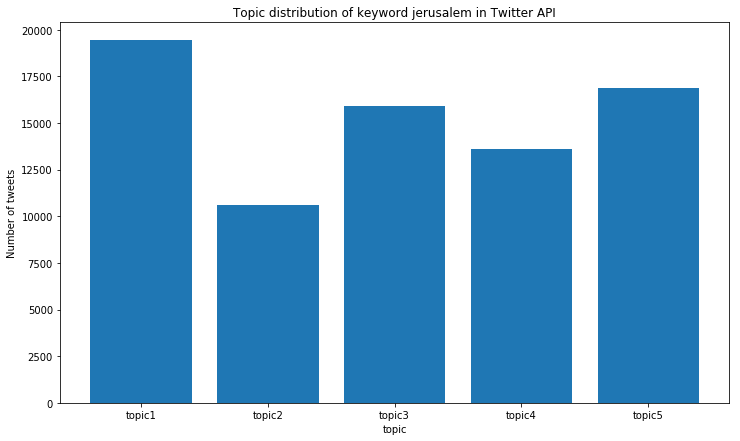

In [120]:
X_topics5_np = np.array(X_topics5)
topic_distribution = np.argmax(X_topics5_np, axis = 1)
topic_count = np.bincount(topic_distribution)

plt.figure(figsize = (12, 7))
plt.bar(range(len(topic_count)), topic_count)
plt.xticks(range(len(topic_count)), ('topic1', 'topic2', 'topic3', 'topic4', 'topic5'))
plt.ylabel('Number of tweets')
plt.xlabel('topic')
plt.title('Topic distribution of keyword jerusalem in Twitter API')
plt.show()

In [121]:
topic_5_1 = X_topics5[:, 0].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_5_1[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

Israel regulator seeks to ban bitcoin firms from stock exchange JERUSALEM Reuters Israels markets regulator said on Monday he will propose regulation to ban companies based on bitcoin and other digital currencies from trading on the Tel Aviv Stock Exchange TASE
--------------------------------------------------

Israel regulator seeks to ban bitcoin firms from stock exchange JERUSALEM Reuters Israels markets regulator said on Monday he will propose regulation to ban companies based on bitcoin and other digital currencies from trading on the Tel Aviv Stock Exchange TASE
--------------------------------------------------

ELITE FUND SOURCE WORTHY BUSINESS NEWS Israel regulator seeks to ban bitcoin firms from stock exchange JERUSALEM Reuters Israels markets regulator said on Monday he will propose regulation to ban companies based on bitcoin and other digital cur
--------------------------------------------------

follow me Israel praises Guatemala over Jerusalem embassy move JERUSALEM/GU

#### The first topic is pretty much identical to the first topic in the 4 topic model. It still has some bitcoin related noise data, but the central theme of this topic is Guatemala and other countries moving their embassies to Jerusalem following Trump's announcement.

In [122]:
topic_5_2 = X_topics5[:, 1].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_5_2[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

I love it thank you Lord watching the enemy turn against their own enemies classic Islamic inbreeding to the extreme and the acute Isn’t Islam the religion of peace ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day Happy Rosh Hashanah Yom Kippur Sukkot Simchat Torah Thanksgiving Hanukkah a very Merry Christmas and a Happy New Year Happy Birthday Jesus💞😇
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day Happy Rosh Hashanah Yom Kippur Sukkot Simchat Torah Thanksgiving Hanukkah a very Merry Christmas and a Happy New Year Happy Birthday Jesus💞😇
--------------------------------------------------

Have a Happy Valentines Day St Patricks Day Purim Passover Easter Mothers Day Jerusalem Day Shavuot Fathers Day H

#### The second topic also consists of Christmas and Pope related topics, but the number of tweets belonging to this class has decreased from 15000 -> 10000.

In [123]:
topic_5_3 = X_topics5[:, 2].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_5_3[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

No Justice No Peace BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS BDS
--------------------------------------------------

amp the Black sea amp ThraceAnatolia amp Karaman amp the City of Dulkadir amp Diyarbakir amp The Lord of Kurdistan Persia AzerbaijanDamascus amp AllepoEgypt amp HijazThe Kingdom of Jerusalem amp all of Arabia amp Yemen amp many more that I amp my Glorious Ancestors with The Will of Allah conquered
--------------------------------------------------

5045 Jerusalem as a spaceport 10257 beacon Pyramids 5620 wars of the Gods amp pyramid 11110 amp 14700 nuke wars 11600 Exodus 11400 Marduk/Babylon 3300 12 planets 3835 Anki bio of 4125 gold expeditions 4510 humanity origin via
--------------------------------------------------

2000 yrs ago Jesus Christ told Jerusalem “ your house is left desolate “ then he evoked the Law of 

#### This is still the history of Jerusalem related topic except the number of tweets belonging to this topic has decreased from 22000 -> 16000.

In [124]:
topic_5_4 = X_topics5[:, 3].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_5_4[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

Jerusalem Israel plans Trump station near Western Wall BBC News BBC News Jerusalem Israel plans Trump station near Western Wall BBC News Israels transport minister wants to dig a railway tunnel under Jerusalems Old City and name a station 
--------------------------------------------------

In Israela Station named after US Prez Trump  For his Historic decision 2 recognise Jerusalem as d capital of Israel Israels transport min Yisrael Katz is finalizing a plan 2 dig a Rly tunnel passing thru HolySites in Jerusalems OldCity amp end at WestWall Trump Station
--------------------------------------------------

Israel considers naming new Jerusalem train station after Donald Trump Israel Transportation Minister Yisrael Katz announced Wednesday his plans to name a new train station near the Western Wall after President Donald Trump the Daily Caller reporte
--------------------------------------------------

Israel considers naming new Jerusalem train station after Donald Trump Israel Transp

#### Good old tweets about a train station being named after Trump.

In [125]:
topic_5_5 = X_topics5[:, 4].argsort()[::-1] #this reverses the order
for iter_idx, movie_idx in enumerate(topic_5_5[:200]):
    print(tweet_df['filtered_tweet'][movie_idx])
    print('-' * 50)
    print()

I think abt Jerusalem aloti pray4Palestine alotas in my childhood my neighbours amp best friends were Palestinians who took care of me whn i lost my mumi use to eat drink play with their kids 24/7 it wz like my homelunch wz always there as my mum use to b their mums good frnd
--------------------------------------------------

🐪🐫Marc Tracy is too stoopid to Rob Lindsey Graham’s Trick Question which turned Elena Kagan to Scotus laughing stock Promoting Chinese Food In Bleeding Jerusalem Back to the answer Yes Israeli Adore Eating Cheap Chinese Kitchen Garbage Stir Fried in Expired Molasses🐪🐫
--------------------------------------------------

Ironic that JK amp Trump r telling us that the left is waging a war on Christmas Theyre both divisive media hogs amp Trumps wreckless policy concerning Jerusalem has created unessessary war during Christmas at its birthplace cancelling local events Did Trump say he likes coal
--------------------------------------------------

Gilead do a little re

#### This last one appears to contain several topics from the violence that has occurred as a result of Jerusalem issue, conflict b/t Isrealies and Palestanians, mention of Nikki Haley who is the ambassador to the United Nations

## 6) Conclusion

#### Reference: https://datascience.stackexchange.com/questions/12281/how-cluster-a-twitter-data-set

Originally, the analysis was going to be performed using K-means clustering, but the above thread made me think twice about that.

Even in the LDA analysis, it was observed that while the algorithm did a decent job picking out important topics, each topic still contained a lot of noise data that were irrelevant. Given more time, it would have been interesting to design a filter that would get rid of noise data, but I'd imagine that in itself would require a lot of work, and would case-by-case depending on the keyword that is being analyzed at hand.

For my next personal project, I would like to do a product evaluation when it just came out so that we could get more legitimate twitter data as opposed to data dominated by advertisements.

## 7) References

https://developer.twitter.com/en/docs/tweets/search/overview

https://datascience.stackexchange.com/questions/12281/how-cluster-a-twitter-data-set

https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

https://www.youtube.com/watch?v=BuMu-bdoVrU

http://blog.mathandpencil.com/using-latent-dirichlet-allocation-to-categorize-my-twitter-feed

Python Machine Learning 2nd Edition, Sebastian Raschka